In [7]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy as sp
import re

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

In [2]:
from preproc import preprocess_and_slice_text_files
import logging
logging.getLogger().setLevel(logging.INFO)


In [3]:
chunk_df = preprocess_and_slice_text_files('../data/txt',overlap_ratio=5)

INFO:root:'BurCom.txt' was processed and split into 124 samples
INFO:root:'AristPha.txt' was processed and split into 104 samples
INFO:root:'BurInt.txt' was processed and split into 320 samples
INFO:root:'AnonMetaph.txt' was processed and split into 309 samples
INFO:root:'BurEthN.txt' was processed and split into 24 samples
INFO:root:'BarMor.txt' was processed and split into 103 samples
INFO:root:'AristMet.txt' was processed and split into 34 samples
INFO:root:'BarMirab.txt' was processed and split into 36 samples
INFO:root:'WilMet.txt' was processed and split into 150 samples
INFO:root:'JamPhys.txt' was processed and split into 265 samples
INFO:root:'WilInPar.txt' was processed and split into 807 samples
INFO:root:'BarMun.txt' was processed and split into 28 samples
INFO:root:'WilTet.txt' was processed and split into 166 samples
INFO:root:'BarSig.txt' was processed and split into 16 samples
INFO:root:'BarPri.txt' was processed and split into 14 samples
INFO:root:'WilInTim.txt' was pro

In [4]:
chunk_df

,Translator,Chunk,Work
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com
1,Bur,dicere et de complexionibus ipsis plurima quid...,Com
2,Bur,quod sicca siccare quecunque vero humida et ca...,Com
3,Bur,humidum existere neque si quid calidum continu...,Com
4,Bur,musicum aut ex alio aliquo heterogenon fieri d...,Com
...,...,...,...
5932,Bur,providentiae opus bene sciens suspicabitur eri...,Fid
5933,Bur,deficient et in pulverem eorum convertent ecce...,Fid
5934,Bur,dicet animas in terrae pulvere dormire sed nem...,Fid
5935,Bur,cum ipso sic dixit sicut dominus resurrexit qu...,Fid


In [5]:

stops = []

with open('../data/functionwords.txt','r') as file:
    for line in file:
        words = [x for x in line.lower().split() if x != '/']
        stops.append(list(set(words)))

flat_stops = [item for sublist in stops for item in sublist]

In [8]:
# doing this without IDF really just makes it a normalised CountVectorizer. Not
# using IDF because the frequency 'boosting' is really a form a fitting, and we
# want to save that for the classification algorithms.

# L1 vs L2 normalisation is a methodological question. Since we'll be clustering
# these as 'points' L2 has slightly more theoretical support, but either would
# almost certainly be fine.
v = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace',norm='l2')
# only count our stopwords
v.fit(flat_stops)

def vectorize(s):
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        ary = sorted(list(set(ary)))
        # each array is a list of spelling variants. sum the counts for all the
        # variants of this stopword that appear in the df, using the first array
        # entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

In [9]:
X = pd.concat([vectorize(x) for x in chunk_df.Chunk],axis=0).reset_index(drop=True)
X

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,0.0,0.024275,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,0.0,0.148979,0.496598,0.0,0.0,0.0,0.124149,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.099320,0.248299,0.024830,0.0,0.223469,0.0
2,0.0,0.161339,0.484018,0.0,0.0,0.0,0.134449,0.0,0.000000,0.0,...,0.000000,0.000000,0.026890,0.0,0.134449,0.188229,0.053780,0.0,0.188229,0.0
3,0.0,0.219447,0.463277,0.0,0.0,0.0,0.073149,0.0,0.000000,0.0,...,0.000000,0.000000,0.024383,0.0,0.097532,0.243830,0.024383,0.0,0.121915,0.0
4,0.0,0.255952,0.535173,0.0,0.0,0.0,0.162879,0.0,0.000000,0.0,...,0.000000,0.000000,0.023268,0.0,0.186147,0.232684,0.023268,0.0,0.069805,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,0.0,0.040893,0.245358,0.0,0.0,0.0,0.204465,0.0,0.000000,0.0,...,0.081786,0.286251,0.000000,0.0,0.040893,0.163572,0.000000,0.0,0.204465,0.0
5933,0.0,0.044588,0.267527,0.0,0.0,0.0,0.312115,0.0,0.000000,0.0,...,0.089176,0.356702,0.000000,0.0,0.000000,0.178351,0.000000,0.0,0.178351,0.0
5934,0.0,0.050833,0.254164,0.0,0.0,0.0,0.304997,0.0,0.000000,0.0,...,0.101666,0.304997,0.000000,0.0,0.000000,0.152499,0.000000,0.0,0.203331,0.0
5935,0.0,0.070711,0.282843,0.0,0.0,0.0,0.353553,0.0,0.000000,0.0,...,0.070711,0.424264,0.000000,0.0,0.000000,0.070711,0.000000,0.0,0.070711,0.0


In [10]:
stops_tidy = pd.concat([chunk_df,X],axis=1).drop('Chunk',axis=1)
stops_tidy

,Translator,Work,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,Com,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,Com,0.0,0.148979,0.496598,0.0,0.0,0.0,0.124149,0.0,...,0.000000,0.000000,0.000000,0.0,0.099320,0.248299,0.024830,0.0,0.223469,0.0
2,Bur,Com,0.0,0.161339,0.484018,0.0,0.0,0.0,0.134449,0.0,...,0.000000,0.000000,0.026890,0.0,0.134449,0.188229,0.053780,0.0,0.188229,0.0
3,Bur,Com,0.0,0.219447,0.463277,0.0,0.0,0.0,0.073149,0.0,...,0.000000,0.000000,0.024383,0.0,0.097532,0.243830,0.024383,0.0,0.121915,0.0
4,Bur,Com,0.0,0.255952,0.535173,0.0,0.0,0.0,0.162879,0.0,...,0.000000,0.000000,0.023268,0.0,0.186147,0.232684,0.023268,0.0,0.069805,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,Bur,Fid,0.0,0.040893,0.245358,0.0,0.0,0.0,0.204465,0.0,...,0.081786,0.286251,0.000000,0.0,0.040893,0.163572,0.000000,0.0,0.204465,0.0
5933,Bur,Fid,0.0,0.044588,0.267527,0.0,0.0,0.0,0.312115,0.0,...,0.089176,0.356702,0.000000,0.0,0.000000,0.178351,0.000000,0.0,0.178351,0.0
5934,Bur,Fid,0.0,0.050833,0.254164,0.0,0.0,0.0,0.304997,0.0,...,0.101666,0.304997,0.000000,0.0,0.000000,0.152499,0.000000,0.0,0.203331,0.0
5935,Bur,Fid,0.0,0.070711,0.282843,0.0,0.0,0.0,0.353553,0.0,...,0.070711,0.424264,0.000000,0.0,0.000000,0.070711,0.000000,0.0,0.070711,0.0


In [11]:
FEATURES = stops_tidy.columns.drop(['Translator','Work'])

In [55]:
stops_tidy[FEATURES] = StandardScaler(with_mean=False).fit_transform(stops_tidy[FEATURES])
stops_tidy

,Translator,Work,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,Com,0.0,0.698752,2.773086,0.0,0.0,0.0,1.537821,0.0,...,0.000000,0.000000,0.000000,0.0,1.173216,2.460511,0.759481,0.0,1.409240,0.0
1,Bur,Com,0.0,1.072087,2.578613,0.0,0.0,0.0,1.310811,0.0,...,0.000000,0.000000,0.000000,0.0,0.800022,2.796394,0.776842,0.0,1.441453,0.0
2,Bur,Com,0.0,1.161032,2.513292,0.0,0.0,0.0,1.419562,0.0,...,0.000000,0.000000,1.194846,0.0,1.082995,2.119877,1.682585,0.0,1.214144,0.0
3,Bur,Com,0.0,1.579187,2.405593,0.0,0.0,0.0,0.772331,0.0,...,0.000000,0.000000,1.083453,0.0,0.785624,2.746064,0.762860,0.0,0.786394,0.0
4,Bur,Com,0.0,1.841888,2.778920,0.0,0.0,0.0,1.719729,0.0,...,0.000000,0.000000,1.033926,0.0,1.499422,2.620537,0.727989,0.0,0.450268,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,Bur,Fid,0.0,0.294275,1.274038,0.0,0.0,0.0,2.158812,0.0,...,1.449781,4.932649,0.000000,0.0,0.329395,1.842184,0.000000,0.0,1.318872,0.0
5933,Bur,Fid,0.0,0.320863,1.389149,0.0,0.0,0.0,3.295410,0.0,...,1.580771,6.146653,0.000000,0.0,0.000000,2.008629,0.000000,0.0,1.150428,0.0
5934,Bur,Fid,0.0,0.365804,1.319764,0.0,0.0,0.0,3.220262,0.0,...,1.802178,5.255675,0.000000,0.0,0.000000,1.717471,0.000000,0.0,1.311559,0.0
5935,Bur,Fid,0.0,0.508849,1.468678,0.0,0.0,0.0,3.732935,0.0,...,1.253453,7.310869,0.000000,0.0,0.000000,0.796359,0.000000,0.0,0.456109,0.0


In [39]:
stops_tidy.to_csv('../data/corpus_oversampled.csv')

In [18]:
myst_3 = stops_tidy[stops_tidy.Work == '3'][FEATURES]
myst_6 = stops_tidy[stops_tidy.Work == '6'][FEATURES]
myst_6

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
3039,0.0,0.766075,2.321658,0.000000,0.0,0.000000,0.224798,0.0,0.0,0.0,...,0.000000,5.870160,0.0,0.576712,1.886503,0.959138,0.0,5.257070,3.570705,0.0
3040,0.0,0.764690,1.765683,0.000000,0.0,0.000000,0.448783,0.0,0.0,0.0,...,0.000000,5.859545,0.0,0.575669,1.198331,1.196754,0.0,2.623782,4.249680,0.0
3041,0.0,0.934451,1.798054,0.000000,0.0,0.000000,0.457011,0.0,0.0,0.0,...,0.000000,5.594033,0.0,0.586223,0.871643,1.218694,0.0,2.671884,4.048391,0.0
3042,0.0,0.547811,1.284671,0.000000,0.0,0.000000,0.401876,0.0,0.0,0.0,...,0.000000,4.919158,0.0,0.515500,0.613189,1.071669,0.0,2.349542,4.296534,0.0
3043,0.0,0.957605,1.151630,0.000000,0.0,0.000000,1.170838,0.0,0.0,0.0,...,0.000000,1.910883,0.0,0.600749,0.178648,1.248892,0.0,2.738091,4.148706,0.0
3044,0.0,0.985896,1.422783,0.000000,0.0,0.000000,1.205428,0.0,0.0,0.0,...,0.000000,0.786934,0.0,0.618497,0.183926,0.771473,0.0,0.000000,3.976700,0.0
3045,0.0,0.853553,1.231793,0.000000,0.0,1.333623,0.751403,0.0,0.0,0.0,...,0.000000,1.226338,0.0,0.000000,0.191084,0.534331,0.0,0.000000,3.978442,0.0
3046,0.0,0.729023,1.315099,0.000000,0.0,1.423816,1.069627,0.0,0.0,0.0,...,0.000000,1.745700,0.0,0.686023,0.612020,0.570467,0.0,0.000000,3.594041,0.0
3047,0.0,0.634138,1.830295,0.000000,0.0,1.651335,1.240548,0.0,0.0,0.0,...,0.000000,2.530819,0.0,0.795646,1.419636,1.984875,0.0,0.000000,2.842058,0.0
3048,0.0,0.213791,2.313971,0.000000,0.0,1.670175,0.627351,0.0,0.0,0.0,...,0.000000,3.071631,0.0,0.804724,1.675138,2.007521,0.0,3.667765,3.066115,0.0


In [16]:
stops_tidy[stops_tidy.Translator=='Wil'].Work.unique()

array(['Met', 'InPar', 'Tet', 'InTim', 'Cael', 'His', 'Elem', 'Simp',
       'GenA', 'Alex'], dtype=object)

In [19]:
wil_test = stops_tidy[stops_tidy.Work.isin(["Simp", "InPar"])][FEATURES]
wil_test

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
1469,0.0,0.419870,3.787064,0.0,0.0,0.0,0.924055,0.0,0.0,0.0,...,2.068541,1.508117,0.000000,0.790211,0.939958,0.328553,0.912723,3.601617,0.188176,0.000000
1470,0.0,0.446290,3.381304,0.0,0.0,0.0,0.982200,0.0,0.0,0.0,...,2.748378,1.068676,1.377864,0.839934,1.498656,0.349226,0.970156,3.828246,0.000000,0.000000
1471,0.0,0.690682,3.322495,0.0,0.0,0.0,1.013373,0.0,0.0,0.0,...,3.402727,0.551297,1.421594,0.866592,1.803924,0.720620,2.001893,3.949747,0.000000,0.000000
1472,0.0,0.695323,3.512064,0.0,0.0,0.0,1.020183,0.0,0.0,0.0,...,3.425593,1.110003,1.431148,0.000000,2.075482,0.725463,2.015346,3.976289,0.000000,0.000000
1473,0.0,0.683719,3.782351,0.0,0.0,0.0,0.668772,0.0,0.0,0.0,...,3.368424,2.728696,1.407263,0.000000,2.295950,0.713356,0.990856,0.000000,0.000000,3.384262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,0.0,0.526083,2.024560,0.0,0.0,0.0,0.257291,0.0,0.0,0.0,...,1.295905,1.259746,0.000000,1.320142,1.570314,4.665537,0.000000,0.000000,0.157185,0.000000
3813,0.0,0.623470,1.649547,0.0,0.0,0.0,0.304920,0.0,0.0,0.0,...,1.023867,1.492947,0.000000,0.782262,1.861006,4.228219,0.903542,0.000000,0.000000,0.000000
3814,0.0,0.307127,1.551292,0.0,0.0,0.0,0.450619,0.0,0.0,0.0,...,1.513097,2.206316,0.000000,1.156048,1.375122,5.767914,1.335279,0.000000,0.000000,0.000000
3815,0.0,0.372107,1.611006,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.916616,0.000000,0.000000,0.000000,1.249548,6.988262,1.617791,0.000000,0.000000,0.000000


In [111]:
min(wil_test.apply(sum,axis=1))

1.6592624117278014

In [52]:
distract_all = stops_tidy[stops_tidy.Translator != 'Myst']
distract_nowil = stops_tidy[(stops_tidy.Translator != 'Myst') & (stops_tidy.Translator != 'Wil')]
distract_nobar = stops_tidy[(stops_tidy.Translator != 'Myst') & (stops_tidy.Translator != 'Bar')]

In [53]:
samp_ctr = Counter(distract_all.Translator)
SAMPLE_SIZE = min(samp_ctr.values())

In [57]:
samp_ctr

Counter({'Bur': 1859,
         'Arist': 185,
         'Anon': 338,
         'Bar': 227,
         'Wil': 2786,
         'Jam': 443})

In [66]:
stops_tidy[stops_tidy.Translator != 'Wil'].groupby('Translator').agg('count')

,Work,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
Translator,,,,,,,,,,,,,,,,,,,,,
Anon,338,338,338,338,338,338,338,338,338,338,...,338,338,338,338,338,338,338,338,338,338
Arist,185,185,185,185,185,185,185,185,185,185,...,185,185,185,185,185,185,185,185,185,185
Bar,227,227,227,227,227,227,227,227,227,227,...,227,227,227,227,227,227,227,227,227,227
Bur,1859,1859,1859,1859,1859,1859,1859,1859,1859,1859,...,1859,1859,1859,1859,1859,1859,1859,1859,1859,1859
Jam,443,443,443,443,443,443,443,443,443,443,...,443,443,443,443,443,443,443,443,443,443
Myst,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99


In [69]:
balance_drop(stops_tidy, 185, ['Wil','Myst'], np.random.RandomState(42))

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,3.307399,1.256061,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.857595,0.416833,0.000000,0.000000,4.091813,0.000000,0.000000,0.00000,2.964599,0.0
1,0.0,0.988849,1.997863,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.461505,0.000000,0.000000,1.488839,2.656469,0.000000,0.859833,0.00000,3.368162,0.0
2,0.0,3.376859,1.661342,0.0,0.0,0.0,0.675621,0.0,0.0,0.0,...,2.268613,0.367552,0.000000,0.577761,3.951677,0.000000,0.000000,0.00000,2.338937,0.0
3,0.0,2.666357,1.331972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,3.031414,0.491138,0.000000,0.000000,1.607076,0.000000,0.000000,0.00000,1.470769,0.0
4,0.0,3.907294,1.127752,0.0,0.0,0.0,0.229312,0.0,0.0,0.0,...,2.309970,1.497010,0.000000,0.000000,2.974051,0.000000,0.000000,2.68132,3.082039,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.0,2.048050,3.564126,0.0,0.0,0.0,0.530279,0.0,0.0,0.0,...,0.890291,1.153932,0.000000,0.453471,0.539405,0.754174,0.000000,0.00000,0.539934,0.0
921,0.0,2.625021,3.389500,0.0,0.0,0.0,1.013539,0.0,0.0,0.0,...,1.020985,0.992497,0.000000,0.520040,0.463942,0.648664,0.000000,0.00000,0.371518,0.0
922,0.0,2.156002,2.916944,0.0,0.0,0.0,0.197706,0.0,0.0,0.0,...,1.659657,1.290678,0.832048,0.507209,0.000000,1.897979,0.000000,0.00000,0.724703,0.0
923,0.0,1.792766,3.283762,0.0,0.0,0.0,0.404671,0.0,0.0,0.0,...,0.679406,2.311569,0.000000,0.000000,2.315447,0.215824,0.000000,0.00000,0.123612,0.0


In [70]:
def balance_drop(df, droplist, rng):
    for tr in droplist:
        df = df[df.Translator != tr]
    samp_ctr = Counter(df.Translator)
    sz = min(samp_ctr.values())
    balance_df = (
        df.groupby("Translator")
        .apply(lambda x: x.sample(sz, random_state=rng))
        .reset_index(drop=True)
    )[FEATURES]
    return balance_df

In [24]:
rng = np.random.RandomState(42)

distract_all = (
        distract_all.groupby("Translator")
        .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
        .reset_index(drop=True)
    )[FEATURES]
distract_all

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,3.307399,1.256061,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.857595,0.416833,0.000000,0.000000,4.091813,0.000000,0.000000,0.000000,2.964599,0.000000
1,0.0,0.988849,1.997863,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1.461505,0.000000,0.000000,1.488839,2.656469,0.000000,0.859833,0.000000,3.368162,0.000000
2,0.0,3.376859,1.661342,0.0,0.0,0.0,0.675621,0.0,0.000000,0.0,...,2.268613,0.367552,0.000000,0.577761,3.951677,0.000000,0.000000,0.000000,2.338937,0.000000
3,0.0,2.666357,1.331972,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,3.031414,0.491138,0.000000,0.000000,1.607076,0.000000,0.000000,0.000000,1.470769,0.000000
4,0.0,3.907294,1.127752,0.0,0.0,0.0,0.229312,0.0,0.000000,0.0,...,2.309970,1.497010,0.000000,0.000000,2.974051,0.000000,0.000000,2.681320,3.082039,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0.0,0.572953,2.687264,0.0,0.0,0.0,0.840641,0.0,0.000000,0.0,...,0.705681,0.342995,0.884460,0.000000,1.442997,1.345025,0.000000,2.457377,0.000000,0.000000
1106,0.0,0.000000,3.045308,0.0,0.0,0.0,0.807679,0.0,0.000000,0.0,...,1.356020,1.318183,1.133039,2.072072,2.875526,2.584569,0.000000,0.000000,0.328954,2.724792
1107,0.0,3.238296,4.154049,0.0,0.0,0.0,0.527917,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.126221,0.000000,0.000000,0.322518,0.000000
1108,0.0,1.158394,3.224034,0.0,0.0,0.0,0.728402,0.0,0.000000,0.0,...,2.445843,0.396266,1.021827,3.114484,0.740938,2.071896,0.719469,0.000000,0.000000,0.000000


In [25]:
rng = np.random.RandomState(42)

distract_nowil = (
        distract_nowil.groupby("Translator")
        .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
        .reset_index(drop=True)
    )[FEATURES]
distract_nowil

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,3.307399,1.256061,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.857595,0.416833,0.000000,0.000000,4.091813,0.000000,0.000000,0.00000,2.964599,0.0
1,0.0,0.988849,1.997863,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.461505,0.000000,0.000000,1.488839,2.656469,0.000000,0.859833,0.00000,3.368162,0.0
2,0.0,3.376859,1.661342,0.0,0.0,0.0,0.675621,0.0,0.0,0.0,...,2.268613,0.367552,0.000000,0.577761,3.951677,0.000000,0.000000,0.00000,2.338937,0.0
3,0.0,2.666357,1.331972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,3.031414,0.491138,0.000000,0.000000,1.607076,0.000000,0.000000,0.00000,1.470769,0.0
4,0.0,3.907294,1.127752,0.0,0.0,0.0,0.229312,0.0,0.0,0.0,...,2.309970,1.497010,0.000000,0.000000,2.974051,0.000000,0.000000,2.68132,3.082039,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.0,2.048050,3.564126,0.0,0.0,0.0,0.530279,0.0,0.0,0.0,...,0.890291,1.153932,0.000000,0.453471,0.539405,0.754174,0.000000,0.00000,0.539934,0.0
921,0.0,2.625021,3.389500,0.0,0.0,0.0,1.013539,0.0,0.0,0.0,...,1.020985,0.992497,0.000000,0.520040,0.463942,0.648664,0.000000,0.00000,0.371518,0.0
922,0.0,2.156002,2.916944,0.0,0.0,0.0,0.197706,0.0,0.0,0.0,...,1.659657,1.290678,0.832048,0.507209,0.000000,1.897979,0.000000,0.00000,0.724703,0.0
923,0.0,1.792766,3.283762,0.0,0.0,0.0,0.404671,0.0,0.0,0.0,...,0.679406,2.311569,0.000000,0.000000,2.315447,0.215824,0.000000,0.00000,0.123612,0.0


In [26]:
distract_nobar = (
        distract_nobar.groupby("Translator")
        .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
        .reset_index(drop=True)
    )[FEATURES]
distract_nobar

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,2.419360,1.309301,0.0,0.0,0.0,0.591617,0.0,0.000000,0.0,...,0.496636,0.965557,0.000000,0.000000,1.128373,0.000000,0.876543,0.0,3.072187,0.000000
1,0.0,0.991474,2.575498,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1.953845,0.000000,0.000000,0.000000,1.331760,0.000000,0.000000,0.0,2.132906,0.000000
2,0.0,2.856257,1.288116,0.0,0.0,0.0,0.523840,0.0,1.451889,0.0,...,0.000000,0.000000,0.000000,0.000000,3.596775,0.000000,0.000000,0.0,3.040257,0.000000
3,0.0,5.395440,1.761200,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.949331,0.307614,0.000000,0.000000,1.581735,0.000000,0.000000,0.0,1.727222,0.000000
4,0.0,3.265129,1.713465,0.0,0.0,0.0,0.217756,0.0,0.000000,0.0,...,1.462368,0.355391,0.916424,0.558645,1.661274,0.000000,0.000000,0.0,2.128517,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.0,2.420235,2.773639,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.701387,0.340908,0.000000,0.000000,0.796787,0.222807,0.000000,0.0,0.127611,2.114054
921,0.0,0.391260,4.799460,0.0,0.0,0.0,1.033308,0.0,0.000000,0.0,...,0.385518,1.124283,0.000000,0.000000,1.138683,0.000000,0.000000,0.0,0.070142,0.000000
922,0.0,0.176412,4.709846,0.0,0.0,0.0,0.258832,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
923,0.0,0.602965,3.154332,0.0,0.0,0.0,0.884674,0.0,1.225993,0.0,...,0.371322,1.443845,0.930788,3.404403,1.856043,0.707738,0.000000,0.0,0.000000,2.238409


In [28]:
def ruzicka(a, b: npt.ArrayLike) -> np.float64:
    npa = np.asarray(a).ravel()
    npb = np.asarray(b).ravel()
    min = np.sum(np.minimum(npa, npb))  # numpy pairwise minimum
    max = np.sum(np.maximum(npa, npb))
    if not (0 <= min / max <= 1):
        raise ValueError("Ruzicka similarity outside [0,1]?")
    return 1 - (min / max)

In [29]:
ruzicka(myst_3.sample(1).to_numpy(), myst_6.sample(1).to_numpy())

0.6763421431768999

In [30]:
from collections import abc

In [31]:
def bs_pairwise_dists(
    in_a,
    in_b,
    outgroup: pd.DataFrame,
    n: int = 1000,
    cols: int = 18,
    dist_fn: abc.Callable = sp.spatial.distance.cosine,
) -> pd.DataFrame:
    res = []
    in_combined = pd.concat([in_a, in_b])
    for _ in range(n):
        in_a_samp = in_a.sample(1).sample(cols, axis=1)
        samp_cols = in_a_samp.columns
        in_samp = [in_a_samp, in_b.sample(1)[samp_cols]]
        out_samp = [in_combined.sample(1)[samp_cols], outgroup.sample(1)[samp_cols]]
        in_dist = dist_fn(in_samp[0], in_samp[1])
        out_dist = dist_fn(out_samp[0], out_samp[1])
        res.append({"dist": out_dist - in_dist})
    return pd.DataFrame(res)

0.025   -0.144888
0.500    0.117243
0.975    0.379396
Name: dist, dtype: float64
19.1


<AxesSubplot:ylabel='Frequency'>

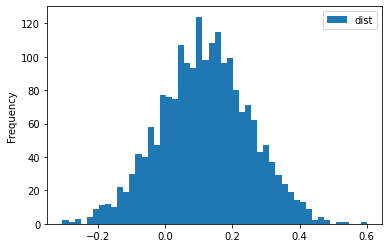

In [34]:
df = bs_pairwise_dists(myst_3, myst_6, distract_all, n=2000, cols=27, dist_fn=ruzicka)
print(df.dist.quantile([0.025,0.5,0.975]))
print(sp.stats.percentileofscore(df.dist,0))
df.plot.hist(bins=50)

0.025   -0.316056
0.500    0.162577
0.975    0.589211
Name: dist, dtype: float64
25.75


<AxesSubplot:ylabel='Frequency'>

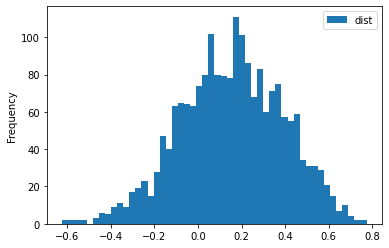

In [33]:
df = bs_pairwise_dists(myst_3, myst_6, distract_all, n=2000, cols=27, dist_fn=sp.spatial.distance.cosine)
print(df.dist.quantile([0.025,0.5,0.975]))
print(sp.stats.percentileofscore(df.dist,0))
df.plot.hist(bins=50)

In [37]:
wil_par = stops_tidy[stops_tidy.Work.isin(["InPar"])][FEATURES]
wil_simp = stops_tidy[stops_tidy.Work.isin(["Simp"])][FEATURES]

0.025   -0.140281
0.500    0.143186
0.975    0.419179
Name: dist, dtype: float64
17.5


<AxesSubplot:ylabel='Frequency'>

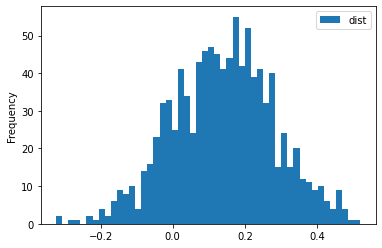

In [38]:
df = bs_pairwise_dists(wil_par, wil_simp, distract_nowil, cols=27, dist_fn=ruzicka)
print(df.dist.quantile([0.025,0.5,0.975]))
print(sp.stats.percentileofscore(df.dist,0))
df.plot.hist(bins=50)

0.025   -0.154411
0.500    0.140251
0.975    0.409192
Name: dist, dtype: float64
17.9


<AxesSubplot:ylabel='Frequency'>

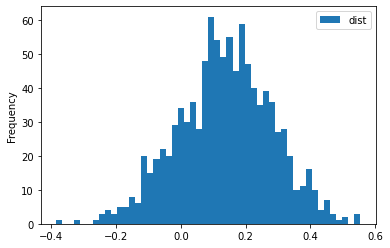

In [79]:
wil_par = stops_tidy[stops_tidy.Work.isin(["InPar"])][FEATURES]
bur = stops_tidy[stops_tidy.Work.isin(["Elem"])][FEATURES]
imposters = balance_drop(stops_tidy, ['Wil','Myst'], np.random.RandomState(42))
df = bs_pairwise_dists(wil_par, bur, imposters, cols=27, dist_fn=ruzicka)
print(df.dist.quantile([0.025,0.5,0.975]))
print(sp.stats.percentileofscore(df.dist,0))
df.plot.hist(bins=50)
